In [ ]:
import torch
import random
import numpy as np
from torch.utils.data import DataLoader, Subset , random_split
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from models import ConvNet
from dataset import RotationDataset
from helper_functions import train_convnet, evaluate_classifier

2024-11-29 16:22:15.718325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-29 16:22:15.728557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732893735.743428 2732702 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732893735.747198 2732702 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 16:22:15.760483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# test hyperparamters:

In [2]:
ROTATION_NUMBER=8
CONV_BLOCKS=4
TRANSFER_LAYERS=2
assert TRANSFER_LAYERS<=CONV_BLOCKS
rotations=[i*360/(ROTATION_NUMBER) for i in range(ROTATION_NUMBER)]

## Datasets

In [3]:
dataset = datasets.MNIST(root='./data', 
                         train=True, 
                         download=True, 
                         transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', 
                        train=False, 
                        download=True, transform=transforms.ToTensor())

## Spliting Data

In [4]:
# Extract targets as a NumPy array
targets = np.array(dataset.targets)

# Select 10 indices for each class
indices = []
for digit in range(10):
    digit_indices = np.where(targets == digit)[0][:10]  # Take first 10 samples for each digit
    indices.extend(digit_indices)


supervised_dataset = Subset(dataset, indices)
unsupervised_dataset=Subset(dataset, np.setdiff1d(range(len(dataset)), indices))

print(f"Supervised dataset: {len(supervised_dataset)} samples")
print(f"Unsupervised dataset: {len(unsupervised_dataset)} samples")

Supervised dataset: 100 samples
Unsupervised dataset: 59900 samples


In [5]:
unsupervised_train_set, unsupervised_val_set = random_split(unsupervised_dataset, 
                                                            [0.9, 0.1])

print(f"Unsupervised training set: {len(unsupervised_train_set)} samples")
print(f"Unsupervised validation set: {len(unsupervised_val_set)} samples")


Unsupervised training set: 53910 samples
Unsupervised validation set: 5990 samples


## Visulaize

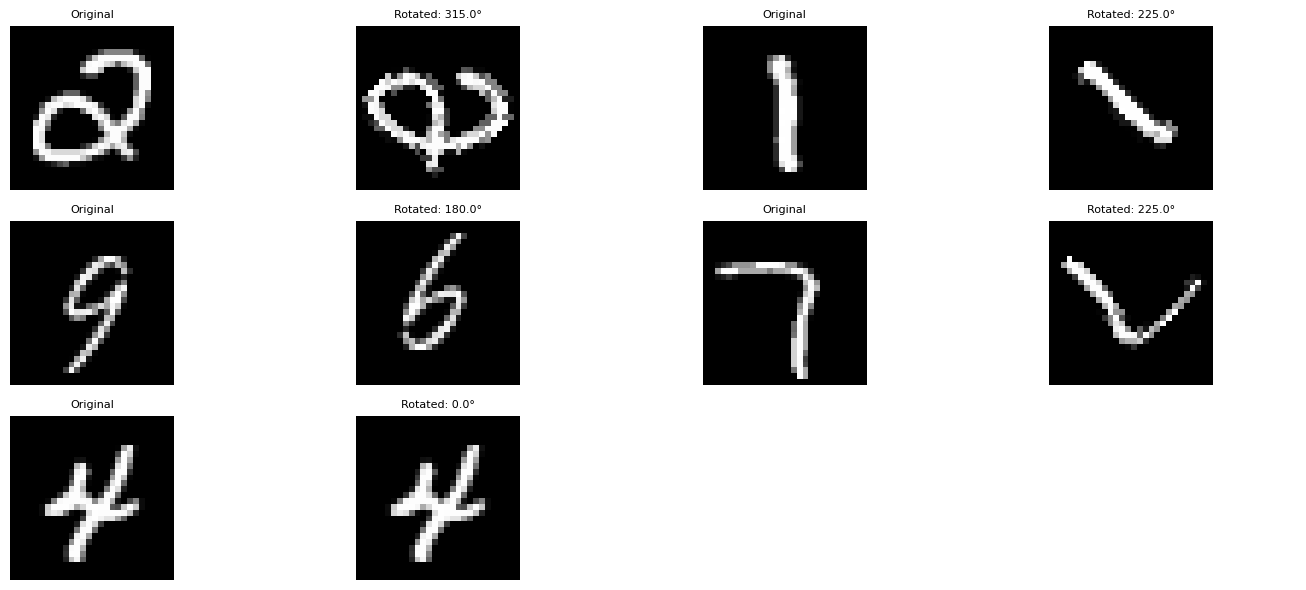

In [6]:
num_images = 5
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols * 2, figsize=(14, num_rows * 2))

for i in range(num_images):
    idx = torch.randint(0, len(unsupervised_train_set), (1,)).item()
    original_image, _ =unsupervised_train_set[idx]

    rotation_angle = random.choice(rotations)
    rotated_image = transforms.functional.rotate(original_image, rotation_angle)

    original_image = original_image.squeeze(0).numpy()
    rotated_image = rotated_image.squeeze(0).numpy()

    row, col = divmod(i, num_cols)
    original_col = col * 2
    rotated_col = col * 2 + 1

    axes[row, original_col].imshow(original_image, cmap='gray')
    axes[row, original_col].set_title("Original", fontsize=8)
    axes[row, original_col].axis('off')

    axes[row, rotated_col].imshow(rotated_image, cmap='gray')
    axes[row, rotated_col].set_title(f"Rotated: {rotation_angle}°", fontsize=8)
    axes[row, rotated_col].axis('off')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()



# Train rotnet

In [7]:
unsupervised_train_loader = DataLoader(RotationDataset(unsupervised_train_set,
                                                       rotations=rotations), 
                                       batch_size=256,
                                       shuffle=True,
                                       num_workers=8,
                                       persistent_workers=True)

unsupervised_val_loader = DataLoader(RotationDataset(unsupervised_val_set,
                                                     rotations=rotations), 
                                     batch_size=256, 
                                     shuffle=False,
                                     num_workers=8,
                                     persistent_workers=True)



In [8]:
rotnet = ConvNet(num_classes=len(rotations)).cuda()
optimizer = torch.optim.Adam(rotnet.parameters(), lr=0.00001,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

train_convnet(rotnet, 
                 unsupervised_train_loader, 
                 unsupervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=10,
                 filename=f'rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth')

    

Epoch 1/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 51.76it/s]


Epoch [1/10] - Train Loss: 1.6017, Train Accuracy: 49.54%, Validation Loss: 1.1823, Validation Accuracy: 68.48%


Epoch 2/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 83.34it/s]


Epoch [2/10] - Train Loss: 0.9639, Train Accuracy: 75.36%, Validation Loss: 0.7763, Validation Accuracy: 81.59%


Epoch 3/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 77.62it/s]


Epoch [3/10] - Train Loss: 0.6661, Train Accuracy: 84.69%, Validation Loss: 0.5527, Validation Accuracy: 88.23%


Epoch 4/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 91.42it/s]


Epoch [4/10] - Train Loss: 0.5005, Train Accuracy: 89.66%, Validation Loss: 0.4301, Validation Accuracy: 91.75%


Epoch 5/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 97.32it/s]


Epoch [5/10] - Train Loss: 0.3996, Train Accuracy: 92.15%, Validation Loss: 0.3525, Validation Accuracy: 93.19%


Epoch 6/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 104.03it/s]


Epoch [6/10] - Train Loss: 0.3295, Train Accuracy: 93.77%, Validation Loss: 0.2886, Validation Accuracy: 95.03%


Epoch 7/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 97.13it/s]


Epoch [7/10] - Train Loss: 0.2801, Train Accuracy: 94.77%, Validation Loss: 0.2502, Validation Accuracy: 95.54%


Epoch 8/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 92.54it/s]


Epoch [8/10] - Train Loss: 0.2414, Train Accuracy: 95.50%, Validation Loss: 0.2153, Validation Accuracy: 96.33%


Epoch 9/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 100.80it/s]


Epoch [9/10] - Train Loss: 0.2123, Train Accuracy: 96.05%, Validation Loss: 0.1902, Validation Accuracy: 96.56%


Epoch 10/10 [Validation]: 100%|██████████| 24/24 [00:00<00:00, 91.58it/s]

Epoch [10/10] - Train Loss: 0.1892, Train Accuracy: 96.48%, Validation Loss: 0.1719, Validation Accuracy: 96.91%


In [9]:
best_model=torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth')

/tmp/ipykernel_2732702/1647972431.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model=torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth')


## Transfer Encoder

#### Load RotNet model

In [10]:
rotnet_model=ConvNet(num_classes=len(rotations))
rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}.pth'))
rotnet_model=rotnet_model.cuda()

/tmp/ipykernel_2732702/1350281749.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotnet_model.load_state_dict(torch.load(f'models/rotnet_{ROTATION_NUMBER}_{CONV_BLOCKS}

### Create MNIST model

In [11]:
MNIST_model = ConvNet(num_classes=10,num_blocks=TRANSFER_LAYERS+1).cuda()

#### Transfer Layers

In [12]:
MNIST_model.transfer_layers(rotnet_model, num_transfer_blocks=TRANSFER_LAYERS)

Transferred 2 blocks from source model to target model.


In [13]:
supervised_train_loader = DataLoader(supervised_dataset, 
                                     batch_size=8, 
                                     shuffle=True,
                                     num_workers=4,
                                     persistent_workers=True)
supervised_val_loader = DataLoader(test_dataset, 
                                   batch_size=8, 
                                   shuffle=False,
                                   num_workers=4,
                                   persistent_workers=True)

optimizer=torch.optim.Adam(MNIST_model.parameters(),lr=0.001,weight_decay=0.001)
learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

train_convnet(MNIST_model, 
                 supervised_train_loader, 
                 supervised_val_loader,
                 nn.CrossEntropyLoss(),
                 optimizer,
                 learning_rate_scheduler, 
                 num_epochs=10,
                 filename=f'rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth')

Epoch 1/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 755.55it/s]


Epoch [1/10] - Train Loss: 2.2827, Train Accuracy: 15.00%, Validation Loss: 2.2965, Validation Accuracy: 19.47%


Epoch 2/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 801.08it/s]


Epoch [2/10] - Train Loss: 1.7525, Train Accuracy: 71.00%, Validation Loss: 2.2209, Validation Accuracy: 11.80%


Epoch 3/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 801.24it/s]


Epoch [3/10] - Train Loss: 1.4464, Train Accuracy: 79.00%, Validation Loss: 1.9493, Validation Accuracy: 25.37%


Epoch 4/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 807.27it/s]


Epoch [4/10] - Train Loss: 1.1849, Train Accuracy: 86.00%, Validation Loss: 1.7178, Validation Accuracy: 37.89%


Epoch 5/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 806.16it/s]


Epoch [5/10] - Train Loss: 1.0089, Train Accuracy: 88.00%, Validation Loss: 1.4192, Validation Accuracy: 61.25%


Epoch 6/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 804.24it/s]


Epoch [6/10] - Train Loss: 0.8240, Train Accuracy: 93.00%, Validation Loss: 1.4901, Validation Accuracy: 47.13%


Epoch 7/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 762.35it/s]


Epoch [7/10] - Train Loss: 0.6902, Train Accuracy: 95.00%, Validation Loss: 1.2560, Validation Accuracy: 63.79%


Epoch 8/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 799.05it/s]


Epoch [8/10] - Train Loss: 0.5685, Train Accuracy: 97.00%, Validation Loss: 1.1822, Validation Accuracy: 65.92%


Epoch 9/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 806.77it/s]


Epoch [9/10] - Train Loss: 0.4314, Train Accuracy: 97.00%, Validation Loss: 1.1904, Validation Accuracy: 61.46%


Epoch 10/10 [Validation]: 100%|██████████| 1250/1250 [00:01<00:00, 765.39it/s]

Epoch [10/10] - Train Loss: 0.3013, Train Accuracy: 100.00%, Validation Loss: 1.1543, Validation Accuracy: 63.04%


In [14]:
best_mnist_model=torch.load(f'models/rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{TRANSFER_LAYERS}.pth')

/tmp/ipykernel_2732702/1409371450.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_mnist_model=torch.load(f'models/rot_mnist_model_{ROTATION_NUMBER}_{CONV_BLOCKS}_{T

In [15]:
evaluate_classifier(MNIST_model, supervised_val_loader)

Test Accuracy: 63.04%
